In [148]:

!pip install emoji
!pip install emoji --upgrade
!pip install langdetect
!pip install tenacity
!pip install deep-translator
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install textblob textblob-fr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 24.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import os
import re
from tqdm import tqdm
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
from deep_translator import GoogleTranslator
from langdetect import detect
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from textblob import TextBlob
import unicodedata
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Programme RNCP/Rendu Bloc C.2/Nettoyage de données (Code)")
from transformers import pipeline
import nltk
from nltk.corpus import stopwords


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.options.display.max_colwidth = 200
tqdm.pandas()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [150]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
FILE_PATH = "free tweet export.csv"
for enc in ["utf-8","utf-8-sig","latin-1"]:
    try:
        df = pd.read_csv(FILE_PATH, encoding=enc)
        break
    except Exception as e:
        last_err = e
else:
    raise RuntimeError(f"Failed to read CSV. Last error: {last_err}")


In [152]:
df.shape[0]

6375

# **Phase de Nettoyage**

Dans cette partie nous allons nettoyer les tweets en procédant de la manière
suivant :

*   Suppression des retweets et des doublons et NaN
*   Suppression des caractères spéciaux, URLs, mentions (@xxx) et remplacement de # par de l'espace (pour ne garder que l'information du hashtag)
* Suppression des ponctuations
*   Détection de langue et traduction en français (si besoin)
* création de le colonne Emoji (utile pour l'analyse)




In [153]:
abbrev_dict = {
    "mdr": "mort de rire",
    "svp": "s'il vous plaît",
    "stp": "s'il te plaît",
    "c": "c est",
    "qd": "quand",
    "j": "je",
    "t": "tu",
    "pk": "pourquoi",
    "bcp": "beaucoup",
    "jpp": "j’en peux plus",
    "pr": "pour",
    "pcq": "parce que",
    "tt": "tout",
    "tt le monde": "tout le monde",
    "tkt": "t inquiète",
    "slt": "salut",
    "bjr": "bonjour",
    "bj": "bonjour",
    "dsl": "désolé",
    "lol": "mort de rire"
}

_EMOJI_RE = re.compile("["
    "\U0001F300-\U0001F5FF"
    "\U0001F600-\U0001F64F"
    "\U0001F680-\U0001F6FF"
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FA6F"
    "\U0001FA70-\U0001FAFF"
    "\u2600-\u26FF"
    "\u2700-\u27BF"
    "]+")
nlp = spacy.load('fr_core_news_sm')

def extract_emojis(t: str) -> str:
    return "".join(_EMOJI_RE.findall(str(t)))

def norm_ws(t):
   return re.sub(r"\s+"," ",str(t)).strip()
def reduce_rep(t):
   return re.sub(r"(.)\1{3,}", r"\1\1\1", str(t))

def split_camel(w):
    parts = re.findall(r"[A-ZÉÈÊÎÏÀÂÇÔÛÜ][a-zàâçéèêëîïôûùüÿñæœ]+|[A-ZÉÈÊÎÏÀÂÇÔÛÜ]+(?=[A-Z][a-z])|[A-Za-zÀ-ÖØ-öø-ÿ]+|\d+", w)
    return " ".join(parts) if len(parts)>1 else w
def rm_punct(text: str, keep_emoji: bool = False) -> str:
    out = []
    for c in str(text):
        if c == " ":
            out.append(c)
        elif c.isalnum():
            out.append(c)
        elif keep_emoji and _EMOJI_RE.match(c):
            out.append(c)
        elif c in ".,;!?()[]{}\"'`:/\\|^~_=+*«»—–-":
            out.append(" ")
    return "".join(out)
def expand_abbrev(t, m):
    for abbr, full in sorted(m.items(), key=lambda kv: len(kv[0]), reverse=True):
        t = re.sub(r"\b"+re.escape(abbr)+r"\b", full, t)
    return t

def filter_tweets(df, text_col='tweet_text', keywords=None):
    df_filtered = df.dropna(subset=[text_col]).copy()
    df_filtered = df_filtered[~df_filtered[text_col].str.startswith(('RT', 'rt'), na=False)].copy()
    df_filtered = df_filtered.drop_duplicates(subset=[text_col])
    return df_filtered


def detect_lang(t):
    try:
        return detect(str(t))
    except Exception:
        s = str(t).lower()
        fr = any(x in s for x in [" le "," la "," les "," des "," pour "," parce "])
        en = any(x in s for x in [" the "," and "," you "," for "])
        es = any(x in s for x in [" el "," la "," los "," gracias "])
        return "fr" if fr else ("en" if en else ("es" if es else "und"))

class TranslationError(Exception):
    pass

@retry(
    reraise=True,
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=0.5, min=0.5, max=8),
    retry=retry_if_exception_type((TranslationError, Exception)),
)
def _translate_once(text: str, src: str | None) -> str:
    try:
        out = GoogleTranslator(source=src or "auto", target="fr").translate(text)
        if not isinstance(out, str) or not out.strip():
            raise TranslationError("Empty translation")
        return out
    except Exception as e:
        raise TranslationError(str(e))

def translate_to_french(text: str, lang_hint: str | None) -> str:

    if text is None:
        return ""
    t = str(text)
    if len(t.strip()) < 3:
        return t
    if (lang_hint or "").lower() == "fr":
        return t
    try:
        return _translate_once(t, src=lang_hint)
    except Exception:
        return t


def cleaning_with_translation(s):
    t = str(s)
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"@\w+", " ", t)
    t = t.replace("#", " ")
    t = t.replace('\n', ' ')
    t = t.replace('\\n', ' ')

    lang = detect_lang(t)
    t_fr_raw = translate_to_french(t, lang)

    t_fr = t_fr_raw.lower()
    t_fr = reduce_rep(t_fr)
    t_fr = " ".join(split_camel(w) for w in t_fr.split())
    t_fr = rm_punct(t_fr, keep_emoji=False)
    t_fr = expand_abbrev(t_fr, abbrev_dict)
    t_fr = _EMOJI_RE.sub(" ", t_fr)
    t_fr = norm_ws(t_fr)

    return lang, t_fr_raw, t_fr

def pipeline_cleaning(text: str) -> dict:
    raw = "" if text is None else str(text)
    emojis = extract_emojis(raw)
    lang, t_fr_raw, t_clean = cleaning_with_translation(raw)
    return {
        "lang": lang,
        "text_translated_fr": t_fr_raw,
        "text_clean": t_clean,
        "emojis": emojis
    }


def run_cleaning_on_df(df: pd.DataFrame, text_col: str) -> pd.DataFrame:
    assert text_col in df.columns, f"Colonne '{text_col}' absente"
    df = df.copy()
    df[text_col] = df[text_col].astype(str)
    df_f = filter_tweets(df, text_col=text_col)
    from tqdm.auto import tqdm
    tqdm.pandas(desc="Cleaning")
    res = df_f[text_col].progress_apply(lambda s: pd.Series(pipeline_cleaning(s)))
    for col in ["lang", "text_translated_fr", "text_clean", "emojis"]:
        df_f[col] = res[col].values
    df_f = df_f.reset_index(drop=True)

    return df_f



In [154]:
df_clean = run_cleaning_on_df(df, 'full_text')

Cleaning:   0%|          | 0/6330 [00:00<?, ?it/s]

In [155]:
df_clean["text_clean"].notna().all()

np.True_

In [156]:
df_clean[['full_text','lang',"text_translated_fr","text_clean","emojis"]]

,full_text,lang,text_translated_fr,text_clean,emojis
0,"💩 à @free parce-que Débit Très instable, … \n\nFree en France: vitesse, performances, pannes et commentaires des utilisateurs\n👉 https://t.co/Yab5ES2gLh\n\n#fing #internet #Free\n\nvia @fingapp @o...",fr,"💩 à parce-que Débit Très instable, … Free en France: vitesse, performances, pannes et commentaires des utilisateurs 👉 internet Free via",à parce que débit très instable free en france vitesse performances pannes et commentaires des utilisateurs internet free via,💩👉
1,"« Faites vos premiers pas avec nous ! Découvrez votre nouveau site d'assistance Freebox et Mobile, sur https://t.co/yw1XX4zeSx 🚀 https://t.co/YCMv79evbM",fr,"« Faites vos premiers pas avec nous ! Découvrez votre nouveau site d'assistance Freebox et Mobile, sur 🚀",faites vos premiers pas avec nous découvrez votre nouveau site d assistance freebox et mobile sur,🚀
2,"FreePlugs et boîtiers CPL personnels : gérer votre réseau CPL 🔗\nOn vous explique comment installer, optimiser et/ou repenser votre réseau CPL afin d'améliorer la liaison avec vos équipements.\nht...",fr,"FreePlugs et boîtiers CPL personnels : gérer votre réseau CPL 🔗 On vous explique comment installer, optimiser et/ou repenser votre réseau CPL afin d'améliorer la liaison avec vos équipements.",freeplugs et boîtiers cpl personnels gérer votre réseau cpl on vous explique comment installer optimiser et ou repenser votre réseau cpl afin d améliorer la liaison avec vos équipements,🔗
3,"Un incident sur nos fibres engendre des perturbations de service sur une partie des départements du Lot (46) et de l'Aveyron (12).\nDes investigations sont en cours, merci de votre patience.",fr,"Un incident sur nos fibres engendre des perturbations de service sur une partie des départements du Lot (46) et de l'Aveyron (12). Des investigations sont en cours, merci de votre patience.",un incident sur nos fibres engendre des perturbations de service sur une partie des départements du lot 46 et de l aveyron 12 des investigations sont en cours merci de votre patience,
4,Les équipes de l’assistance Free vous souhaitent de joyeuses fêtes ! Nos services profitent aussi des fêtes ce 25 décembre et seront de retour le 26 dès 9h00 ! 🎅🏻🎁 https://t.co/dhPpFn9nfG,fr,Les équipes de l’assistance Free vous souhaitent de joyeuses fêtes ! Nos services profitent aussi des fêtes ce 25 décembre et seront de retour le 26 dès 9h00 ! 🎅🏻🎁,les équipes de l assistance free vous souhaitent de joyeuses fêtes nos services profitent aussi des fêtes ce 25 décembre et seront de retour le 26 dès 9 h 00,🎅🏻🎁
...,...,...,...,...,...
6325,"Bonjour @free , c'est bien long pour trouver un créneau, ça fait 2 ans bientôt que vous m'avez promis la fibre, visiblement les actes ne suivent pas les promesses. De plus les deux derniers rdv, n...",fr,"Bonjour , c'est bien long pour trouver un créneau, ça fait 2 ans bientôt que vous m'avez promis la fibre, visiblement les actes ne suivent pas les promesses. De plus les deux derniers rdv, n'ont...",bonjour c est est bien long pour trouver un créneau ça fait 2 ans bientôt que vous m avez promis la fibre visiblement les actes ne suivent pas les promesses de plus les deux derniers rdv n ont pas...,
6326,"@maarylou_v Bonjour,\n\nLa messagerie privée X n’est plus disponible, et nous en sommes désolés. \nRetrouvez-nous dès à présent sur Messenger :\n▶️ https://t.co/foZUyQkGH3\n\nNous sommes également...",fr,"Bonjour, La messagerie privée X n’est plus disponible, et nous en sommes désolés. Retrouvez-nous dès à présent sur Messenger : ▶️ sommes également disponibles via d'autres canaux : ▶️ - Free",bonjour la messagerie privée x n est plus disponible et nous en sommes désolés retrouvez nous dès à présent sur messenger sommes également disponibles via d autres canaux free,
6327,"@iac_yac Bonjour,\n\nLa messagerie privée X n’est plus disponible.\n\nRetrouvez-moi dès à présent sur Messenger si vous avez toujours besoin d'asssitance :\n▶️ https://t.co/foZUyQkGH3\n\nNous somm...",fr

In [157]:

df_clean.to_csv('/content/df_clean.csv', index=False, encoding='utf-8-sig')
files.download('/content/df_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Pré-processing**
Les étapes



*   Charger spaCy FR (ou blank("fr") en secours) et récupère les stopwords.
*   Tokenise les tweets nettoyés avec spaCy.
*   Pour chaque token : on prend le lemme (sinon le mot en minuscule).
*   Filtrer tout ce qui n’est pas alphabétique et retirer les stopwords.
*  Assembler les tokens restants en une chaîne (séparée par des espaces) prête pour la modélisation.











In [158]:
try:
    nlp = spacy.load("fr_core_news_sm")
except Exception:
    nlp = spacy.blank("fr")

STOP = {w.lower() for w in getattr(nlp.Defaults, "stop_words", set())}
NEGATIONS_TO_KEEP = {"pas", "plus", "jamais", "rien", "aucun", "personne"}
STOP = STOP.difference(NEGATIONS_TO_KEEP)

def preproc_series(texts, keep_numbers: bool = False, batch_size: int = 1000, n_process: int = 1):
    results = []
    generator = ("" if pd.isna(x) else str(x) for x in texts)
    for doc in tqdm(
        nlp.pipe(generator, batch_size=batch_size, n_process=n_process),
        total=len(texts), desc="Preproc"
    ):
        toks = []
        for tok in doc:
            if not (tok.is_alpha or (keep_numbers and tok.like_num)):
                continue
            lemma = (tok.lemma_ or tok.text).lower()
            if not lemma or lemma == "nan" or lemma in STOP:
                continue
            toks.append(lemma)
        results.append(" ".join(toks))
    return results

In [159]:
df_clean["text_preproc"] = preproc_series(df_clean["text_clean"])

Preproc: 100%|██████████| 6330/6330 [00:26<00:00, 234.84it/s]


In [160]:
len(df_clean)

6330

In [161]:
path = "/content/drive/MyDrive/Programme RNCP/Rendu Bloc C.2/Nettoyage de données (Code)/df_preprocessed.csv"
df_clean["text_clean"] = df_clean["text_clean"].fillna("").astype("string")
df_clean.to_csv(path, index=False, encoding="utf-8-sig", na_rep="")


In [162]:
df_clean["text_clean"].isna().sum()
len(df_clean)

6330

In [163]:
df= pd.read_csv('/content/drive/MyDrive/Programme RNCP/Rendu Bloc C.2/Nettoyage de données (Code)//df_preprocessed.csv',encoding="utf-8-sig", keep_default_na=False)

In [164]:
len(df)

6330

In [165]:
# Normaliser le texte pour éviter les différences de casse
df["screen_name_lower"] = df["screen_name"].str.lower()
# Dataset 1 : noms ne contenant pas "free"
df_client = df[~df["screen_name_lower"].str.contains("free", na=False)]
# Dataset 2 : noms contenant "free"
df_free = df[df["screen_name_lower"].str.contains("free", na=False)]

In [166]:
# Vérification
print("All Tweets :", len(df))
print("Tweets clients :", len(df_client))
print("Tweets Free :", len(df_free))

All Tweets : 6330
Tweets clients : 3035
Tweets Free : 3295


**Volume de tweets SAV (par jour/semaine)**

Volume par jour

In [167]:
# Volume de tweet reçu
df_client["created_at"] = pd.to_datetime(df_client["created_at"], errors="coerce", utc=True)
volume_jour = df_client.groupby(df_client['created_at'].dt.date).size()
tweets_par_jour = volume_jour.reset_index(name='volumes')
top_volume = tweets_par_jour.sort_values(by='volumes', ascending=False)
print(top_volume.head())

     created_at  volumes
14   2024-07-19      113
109  2024-10-22       50
89   2024-10-02       49
24   2024-07-29       44
90   2024-10-03       39


/tmp/ipython-input-2831004310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client["created_at"] = pd.to_datetime(df_client["created_at"], errors="coerce", utc=True)


**Analyse des volumes par jour** :
  Comme le montre le code précédent on constate que la journée du 2024-07-19 est celle qui a enregistrer le plus tweets clients avec un volume de 113 suivi de la journée du 2024-10-22 avec 50 et celle du 2024-10-02 avec 49.
  On peut aussi noter que la journée du ... est la celle qui a enregistrer le moins de tweets.

Volume par semaine

In [168]:
# Volume de tweet reçu
df_client["created_at"] = pd.to_datetime(df_client["created_at"], errors="coerce", utc=True)
volume_semaine = df_client.groupby(df_client['created_at'].dt.to_period('W')).size()
tweets_par_semaine = volume_semaine.reset_index(name='volumes')
top_volume = tweets_par_semaine.sort_values(by='volumes', ascending=False)
print(top_volume.head())

               created_at  volumes
20  2024-09-30/2024-10-06      181
16  2024-09-02/2024-09-08      167
9   2024-07-15/2024-07-21      152
23  2024-10-21/2024-10-27      145
29  2024-12-02/2024-12-08      138


/tmp/ipython-input-3391684988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client["created_at"] = pd.to_datetime(df_client["created_at"], errors="coerce", utc=True)
/tmp/ipython-input-3391684988.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  volume_semaine = df_client.groupby(df_client['created_at'].dt.to_period('W')).size()


**Analyse des volumes par semaine** :
  Comme le montre le code précédent on constate que la semaine 20 est celle qui a enregistré le plus tweets clients avec un volume de 181 suivi de la
  semaine 16 avec 167 et de la semaine 9 avec 152.
  on peut aussi noter que le semaine ... est la celle qui a enregistrer le moins de tweets.

In [169]:
# Volume de tweet repondu par free
df_free["created_at"] = pd.to_datetime(df_free["created_at"], errors="coerce", utc=True)
volume_semaine = df_free.groupby(df_free['created_at'].dt.to_period('W')).size()
tweets_par_semaine = volume_semaine.reset_index(name='volumes')
top_volume = tweets_par_semaine.sort_values(by='volumes', ascending=False)
print(top_volume.head())

               created_at  volumes
20  2024-08-19/2024-08-25      302
28  2024-10-14/2024-10-20      194
29  2024-10-21/2024-10-27      190
33  2024-11-18/2024-11-24      187
26  2024-09-30/2024-10-06      187


/tmp/ipython-input-1489064894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_free["created_at"] = pd.to_datetime(df_free["created_at"], errors="coerce", utc=True)
/tmp/ipython-input-1489064894.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  volume_semaine = df_free.groupby(df_free['created_at'].dt.to_period('W')).size()


**Analyse des tweetw de free par semaine** : on note que la semaine 20 est celle qui enregistrer le plus de tweets de la part de free ce qui est logique vu que c'est la même semaine qui a enregistré le plus de tweets clients.

**Proportion des tweets (positifs, négatifs, neutres)**

In [170]:
# Classification des sentiments
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment"
)

Device set to use cpu


In [171]:
def sentiments(text):
    try:
        result = sentiment_pipeline(str(text)[:512])[0]
        return pd.Series([result['label'], result['score']])
    except Exception:
        return pd.Series([None, None])

df_client[['sentiment', 'score']] = df_client['text_clean'].apply(sentiments)
df_client.head()

/tmp/ipython-input-3541307288.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client[['sentiment', 'score']] = df_client['text_clean'].apply(sentiments)
/tmp/ipython-input-3541307288.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client[['sentiment', 'score']] = df_client['text_clean'].apply(sentiments)


,id,created_at,full_text,media,screen_name,name,profile_image_url,user_id,in_reply_to,retweeted_status,quoted_status,media_tags,favorite_count,retweet_count,bookmark_count,quote_count,reply_count,views_count,favorited,retweeted,bookmarked,url,lang,text_translated_fr,text_clean,emojis,text_preproc,screen_name_lower,sentiment,score
0,1343458257915031553,2020-12-28 07:26:23+00:00,"💩 à @free parce-que Débit Très instable, … \n\nFree en France: vitesse, performances, pannes et commentaires des utilisateurs\n👉 https://t.co/Yab5ES2gLh\n\n#fing #internet #Free\n\nvia @fingapp @o...",[],m_annuel,M Annuel,https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png,1104790986801250304,,,,[],2,1,0,0,1,,False,False,False,https://twitter.com/m_annuel/status/1343458257915031553,fr,"💩 à parce-que Débit Très instable, … Free en France: vitesse, performances, pannes et commentaires des utilisateurs 👉 internet Free via",à parce que débit très instable free en france vitesse performances pannes et commentaires des utilisateurs internet free via,💩👉,débit instable free france vitesse performance panne commentaire utilisateur internet free,m_annuel,negative,0.899980
7,1480465391424053249,2022-01-10 09:03:49+00:00,🎂 @free célèbre aujourd'hui 10 ans de révolution mobile ! Notre CP 👉 https://t.co/4wiuxqOx9b https://t.co/c1e4svvexn,"[{""type"":""video"",""url"":""https://t.co/c1e4svvexn"",""thumbnail"":""https://pbs.twimg.com/ext_tw_video_thumb/1480464545055453185/pu/img/hKX4D3miTiISobYD.jpg?name=thumb"",""original"":""https://video.twimg.c...",GroupeIliad,Groupe iliad,https://pbs.twimg.com/profile_images/1273657686203170818/PBEYgUCT_normal.jpg,3157961111,,,,[],80,17,2,0,39,,False,False,False,https://twitter.com/GroupeIliad/status/1480465391424053249,fr,🎂 célèbre aujourd'hui 10 ans de révolution mobile ! Notre CP 👉,célèbre aujourd hui 10 ans de révolution mobile notre cp,🎂👉,célèbre aujourd an révolution mobile cp,groupeiliad,positive,0.759299
9,1485331097844129798,2022-01-23 19:18:24+00:00,Et vous ça se passe comment la fibre ?\n@Sosh_fr @CovageIDF_OUEST c’est la misère vraiment jpp https://t.co/I41UXroh0F,"[{""type"":""photo"",""url"":""https://t.co/I41UXroh0F"",""thumbnail"":""https://pbs.twimg.com/media/FJz0vDiXIAAmTmd?format=jpg&name=thumb"",""original"":""https://pbs.twimg.com/media/FJz0vDiXIAAmTmd?format=jpg&...",MitchelMcPat,MitchelMcPat,https://pbs.twimg.com/profile_images/1771992854971203584/P-EuAmK3_normal.jpg,906220646492983296,,,,[],0,0,1,0,3,,False,False,False,https://twitter.com/MitchelMcPat/status/1485331097844129798,fr,Et vous ça se passe comment la fibre ? c’est la misère vraiment jpp,et vous ça se passe comment la fibre c est est la misère vraiment je’en peux plus,,passer fibre c misère vraiment plus,mitchelmcpat,negative,0.951364
13,1694675653205860558,2023-08-24 11:38:55+00:00,"Dans la lutte contre les installations sauvages et les infrastructures dégradées, la bonne formation des techniciens qui déploient la fibre est essentielle. J'étais ce matin aux côtés d'Idriss, fo...","[{""type"":""photo"",""url"":""https://t.co/nKKA40veRw"",""thumbnail"":""https://pbs.twimg.com/media/F4SyhckW8AAHxGN?format=jpg&name=thumb"",""original"":""https://pbs.twimg.com/media/F4SyhckW8AAHxGN?format=jpg&...",jnbarrot,Jean-Noël Barrot,https://pbs.twimg.com/profile_images/1912992083243159552/c1lP9dZv_normal.jpg,865482011523166209,,,,"[{""user_id"":""3001096995"",""name"":""Arcep"",""screen_name"":""Arcep"",""type"":""user""},{""user_id"":""394743295"",""name"":""Fédération Française des Télécoms"",""screen_name"":""FFTelecoms"",""type"":""user""},{""user_id"":...",112,35,0,2,14,9127.0,False,False,False,https://twitter.com/jnbarrot/status/1694675653205860558,fr,"Dans la lutte contre les installations sauvages et les infrastructures dégradées, la bonne formation des techniciens qui déploient la fibre est essentielle. J'étais ce matin aux côtés d'Idriss, fo...",dans la lutte contre les installations sauvages et les infrastructures dégradées

Pourquoi ce modèle :

le modèle **cardiffnlp/twitter-xlm-roberta-base-sentiment** est parfait pour notre cas :

car entraîné sur Twitter (vocabulaire court, familier, émoticônes, hashtags, etc.), multilingue (marche très bien en français) et renvoie 3 classes : Negative, Neutral, Positive

Notre classification des sentiments a permis la création des colonnes sentiments et score qui recensent pour avoir une vue d'ensemble sur les différents tweets.

Les différentes langues dans le csv

Répartition des tweets

In [172]:
# Calcul des Proporttions
proportions = df_client['sentiment'].value_counts(normalize=True) * 100
print(proportions)

sentiment
negative    80.955519
neutral     11.729819
positive     7.314662
Name: proportion, dtype: float64


lLe modèle **cardiffnlp** nous a permis d'avoir les tweets clients en 3 catégories : négative avec 80,95% ; neutre avec 11,72 et positive avec 7,31%

**Répartition par thèmes (problème technique, abonnement, réseau, facture...)**

In [173]:
themes = {
    "Technique": [
        "panne", "connexion", "wifi", "décodeur", "box", "routeur",
        "signal", "erreur", "écran noir", "redémarrage"
    ],
    "Réseau": [
        "réseau", "4g", "5g", "mobile", "antenne", "coupure", "débit"
    ],
    "Abonnement": [
        "abonnement", "résiliation", "forfait", "offre", "changement", "portabilité"
    ],
    "Facturation": [
        "facture", "paiement", "prélèvement", "montant", "remboursement"
    ],
    "Service client": [
        "support", "hotline", "assistance", "appel", "injoignable", "attente"
    ],
    "Urgence": [
        "urgent", "aucun accès", "plus d’internet", "ça fait", "2 jours", "bloqué"
    ]
}

In [174]:
# Classification des thèmatiques
classifier = pipeline(
    "zero-shot-classification",
    model="joeddav/xlm-roberta-large-xnli"
)

'# Classification des thèmatiques\nclassifier = pipeline(\n    "zero-shot-classification",\n    model="joeddav/xlm-roberta-large-xnli"\n)'

In [175]:
def classify_tweet_zero_shot(text: str) -> str:
    if not isinstance(text, str) or text.strip() == "":
        return "Autre"

    labels = list(themes.keys())

    result = classifier(
        text,
        candidate_labels=labels,
        multi_label=False
    )

    return result["labels"][0]

'def classify_tweet_zero_shot(text: str) -> str:\n    if not isinstance(text, str) or text.strip() == "":\n        return "Autre"\n\n    # Convertit le dict -> liste de labels\n    labels = list(themes.keys())\n\n    result = classifier(\n        text,\n        candidate_labels=labels,\n        multi_label=False\n    )\n\n    return result["labels"][0]\n'

In [176]:
df_client["theme"] = df_client["text_clean"].apply(classify_tweet_zero_shot)

# Affichage
print(df_client.head())

'df_client["theme"] = df_client["text_clean"].apply(classify_tweet_zero_shot)\n\n# Affichage\nprint(df_client.head())'

In [177]:
'''def get_theme(text_clean):
    if pd.isna(text_clean):
        return "Autre"
    text_clean = str(text_clean).lower()
    for theme, mots in themes.items():
        if any(re.search(rf"\b{re.escape(mot)}\b", text_clean) for mot in mots):
            return theme
    return "Autre"

df_client["theme"] = df_client["text_clean"].apply(get_theme)'''

/tmp/ipython-input-1387821246.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client["theme"] = df_client["text_clean"].apply(get_theme)


In [178]:
# Répartition des thèmes
repartition_themes = df_client["theme"].value_counts(normalize=True) * 100
print(repartition_themes.round(1))

theme
Autre             50.2
Technique         27.7
Abonnement         6.6
Réseau             6.3
Service client     4.2
Urgence            4.0
Facturation        1.1
Name: proportion, dtype: float64


**Analyse des thèmes** : voir avec chérif

Tweets avec mentions d’urgence

In [179]:
urgent_patterns = [
    r"urgent",
    r"s'il te plait|svp|please|help",
    r"aucun accès|sans internet|sans réseau|plus d'internet",
    r"toujours rien|toujours pas|encore rien",
    r"ça fait \d+ jours|depuis \d+ jours|depuis hier",
    r"injoignable|bloqué|bloquee|bloqué",
    r"panne totale|coupure totale",
    r"scandale|inadmissible|honteux|abusé",
    r"impossible de|ne fonctionne pas du tout",
]


In [180]:
import re

def detect_urgence(text_clean):
    if pd.isna(text_clean):
        return 0  # 0 = pas urgent

    text_clean = str(text_clean).lower()

    for pattern in urgent_patterns:
        if re.search(pattern, text_clean):
            return 1  # 1 = urgent
    return 0

df_client["urgent"] = df_client["text_clean"].apply(detect_urgence)

/tmp/ipython-input-465216455.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client["urgent"] = df_client["text_clean"].apply(detect_urgence)


In [181]:
nb_urgents = df_client["urgent"].sum()
print(f"Tweets urgents: {nb_urgents}")

Tweets urgents: 550


In [182]:
df_urgent = df_client[df_client["urgent"] == 1]
df_urgent.head()

,id,created_at,full_text,media,screen_name,name,profile_image_url,user_id,in_reply_to,retweeted_status,quoted_status,media_tags,favorite_count,retweet_count,bookmark_count,quote_count,reply_count,views_count,favorited,retweeted,bookmarked,url,lang,text_translated_fr,text_clean,emojis,text_preproc,screen_name_lower,sentiment,score,theme,urgent
21,1762571081402011959,2024-02-27 20:11:07+00:00,Ça fonctionne super bien la Fibre Free ce soir... Franchement c'est abusé. Déjà l'autre soir la TV de Free (OQEE) était carrément indisponible ! #FTTH #fibre #Free #Var @Freebox @Free_1337 @free h...,"[{""type"":""photo"",""url"":""https://t.co/UwrutxJMD9"",""thumbnail"":""https://pbs.twimg.com/media/GHXo1b7WIAAbMbt?format=jpg&name=thumb"",""original"":""https://pbs.twimg.com/media/GHXo1b7WIAAbMbt?format=jpg&...",nephthys,Camille Bouiller,https://pbs.twimg.com/profile_images/1189240389196271616/cR7wwXfh_normal.jpg,11038512,,,,[],1,1,0,0,4,1070.0,False,False,False,https://twitter.com/nephthys/status/1762571081402011959,fr,Ça fonctionne super bien la Fibre Free ce soir... Franchement c'est abusé. Déjà l'autre soir la TV de Free (OQEE) était carrément indisponible ! FTTH fibre Free Var,ça fonctionne super bien la fibre free ce soir franchement c est est abusé déjà l autre soir la tv de free oqee était carrément indisponible ftth fibre free var,,fonctionner super bien fibre free soir franchement c abuser l soir tv free oqee carrémer indisponible ftth fibre free var,nephthys,negative,0.523690,Autre,1
35,1813581407668871481,2024-07-17 14:27:56+00:00,"@free comment vous joindre ? j'ai été débité pour non restitution de matériel pour une résiliation de ligne que je n'ai pas effectuée moi même, impossible de vous joindre car mes identifiants n ex...",[],fannnoche,fannoche,https://pbs.twimg.com/profile_images/1245059874536423427/l-TF7zS9_normal.jpg,874295773,,,,[],0,0,0,0,2,18.0,False,False,False,https://twitter.com/fannnoche/status/1813581407668871481,fr,"comment vous joindre ? j'ai été débité pour non restitution de matériel pour une résiliation de ligne que je n'ai pas effectuée moi même, impossible de vous joindre car mes identifiants n existe...",comment vous joindre je ai été débité pour non restitution de matériel pour une résiliation de ligne que je n ai pas effectuée moi même impossible de vous joindre car mes identifiants n existent p...,,joindre débité non restitution matériel résiliation ligne n pas effectuer impossible joindre identifiant n exister plus relance arriver,fannnoche,negative,0.894179,Abonnement,1
48,1813867624843055326,2024-07-18 09:25:16+00:00,"@Freebox Bonjour, mes parents ont fait leur inscription ( enfin ! ) le 9, et depuis pas de nouvelle toujours bloqué à cette étape, c'est normal ? https://t.co/NZRZz77fdu","[{""type"":""photo"",""url"":""https://t.co/NZRZz77fdu"",""thumbnail"":""https://pbs.twimg.com/media/GSwm0KzWUAAp0u7?format=png&name=thumb"",""original"":""https://pbs.twimg.com/media/GSwm0KzWUAAp0u7?format=png&...",hnchck,Quentin,https://pbs.twimg.com/profile_images/1814021212034433024/N9U9VIDu_normal.jpg,2719734105,,,,[],0,0,0,0,1,82.0,False,False,False,https://twitter.com/hnchck/status/1813867624843055326,fr,"Bonjour, mes parents ont fait leur inscription ( enfin ! ) le 9, et depuis pas de nouvelle toujours bloqué à cette étape, c'est normal ?",bonjour mes parents ont fait leur inscription enfin le 9 et depuis pas de nouvelle toujours bloqué à cette étape c est est normal,,bonjour parent faire inscription pas bloquer étape c normal,hnchck,negative,0.557434,Urgence,1
51,1813977091500802109,2024-07-18 16:40:15+00:00,@Freebox je ne comprend pas une amie abonnée chez vous avec la delta depuis 2 ans on lui a offert les frais de migration vers la ultra. Moi je suis abonné chez vous depuis 2009 et a moi on me fait...,[],jacquesnote,jacques,https://pbs.twimg.com/profile_images/863818061928951814/1-9TQoRK_normal.jpg,85842120,,,,[],0,1,0,0,1,78.0,False,False,False,https://twitter.com/jacquesnote/status/1813977091500802109

In [183]:
pourcentage = df_client["urgent"].mean() * 100
print(f"{pourcentage:.2f}% des tweets sont urgents")

18.12% des tweets sont urgents


**Analyse des tweets à caractère urgent** : voir avec chérif

**Exploration visuelle**

/tmp/ipython-input-1276116636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client["created_at"] = pd.to_datetime(df_client["created_at"], errors="coerce", utc=True)
/tmp/ipython-input-1276116636.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_2024.groupby([df_2024["created_at"].dt.to_period("W"), "sentiment"])


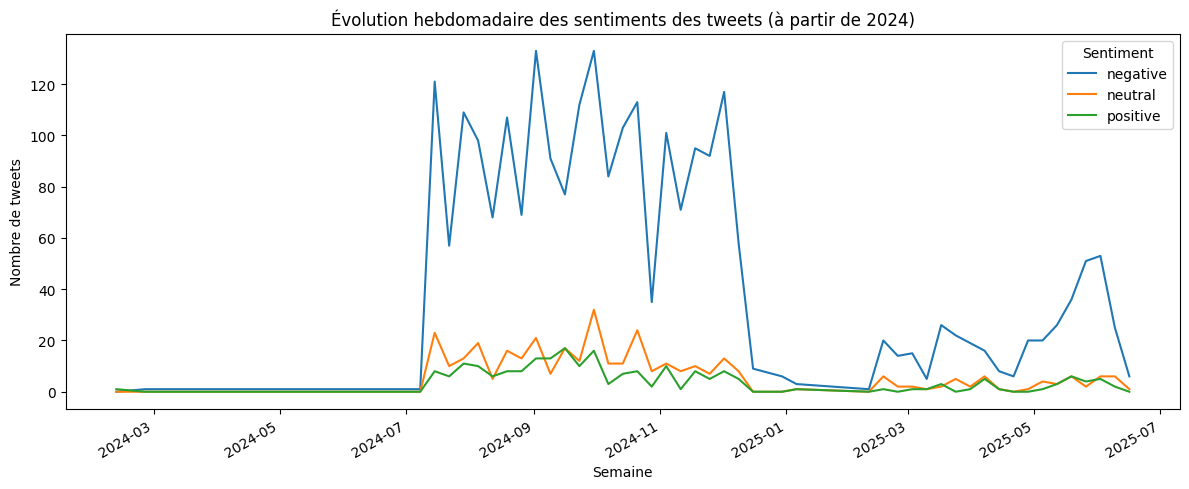

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Assure-toi que la colonne est datetime
df_client["created_at"] = pd.to_datetime(df_client["created_at"], errors="coerce", utc=True)
df_2024 = df_client[df_client["created_at"] >= pd.Timestamp("2024-01-01", tz="UTC")]
sentiment_temps = (
    df_2024.groupby([df_2024["created_at"].dt.to_period("W"), "sentiment"])
    .size()
    .unstack(fill_value=0)
)

# Optionnel : conversion Period → date pour un meilleur affichage
sentiment_temps.index = sentiment_temps.index.to_timestamp()
sentiment_temps.plot(kind="line", figsize=(12,5))
plt.title("Évolution hebdomadaire des sentiments des tweets (à partir de 2024)")
plt.xlabel("Semaine")
plt.ylabel("Nombre de tweets")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


**Analyse temporelle des tweets**

Début 2024 (janvier → juillet) :
L'activité reste faible voire quasi inexistante, avec un volume constant et très bas. Cela indique que durant cette période, peu de clients utilisaient Twitter pour contacter Free ou qu’il n’y avait pas d’événements majeurs ou pas le posibilité de les contacter par X.

Fin août 2024 → décembre 2024 : montée soudaine et forte activité
À partir de fin août, on observe une augmentation nette du nombre de tweets, atteignant un pic majeur entre septembre et novembre 2024.
Ce pic correspond pourrait correspondre à un événement marquant (voir nos thématiques).Durant cette période, les tweets négatifs dominent très largement, traduisant une insatisfaction forte et concentrée dans le temps.

Janvier 2025 → mi-2025 : baisse progressive mais activité soutenue
Le volume diminue progressivement après les pics, mais ne revient jamais au niveau initial du début de 2024.
Cela suggère que X s’installe comme canal régulier de support, même après la période critique.

En somme on peut dire que : L’évolution temporelle montre une transformation de l’usage de Twitter par les clients de Free : d’un canal marginal en début d’année, il devient un point de contact majeur lors d’un événement critique à la fin 2024. Le volume retombe ensuite mais reste supérieur au niveau initial, indiquant un changement durable des habitudes d’expression et de demande d’assistance des utilisateurs.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


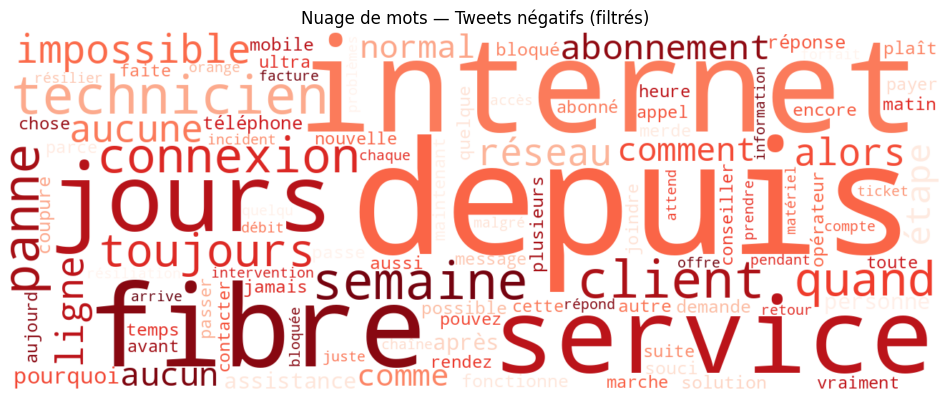

In [185]:
nltk.download("stopwords")
from wordcloud import WordCloud

stopwords_fr = set(stopwords.words("french"))
custom_stopwords = {
    "free", "freebox", "bonjour", "svp", "merci", "problème",
    "aidez", "bonjour", "rt", "svp", "hello",
    "faire", "avoir", "être", "plus"
}

# Fusion des stopwords standard + custom
stopwords_total = stopwords_fr.union(custom_stopwords)
negatifs = df_client[df_client["sentiment"].str.lower() == "negative"]["text_clean"].dropna()

# Nettoyage : mots > 3 caractères + non stopwords
negatifs_filtrees = [
    " ".join([mot for mot in str(tweet).split() if len(mot) > 4 and mot not in stopwords_total])
    for tweet in negatifs
]

# Génération texte final
texte_neg = " ".join(negatifs_filtrees)
if len(texte_neg.strip()) > 0:
    wordcloud = WordCloud(
        width=1300,
        height=500,
        background_color="white",
        max_words=100,
        collocations=False,
        colormap="Reds"
    ).generate(texte_neg)

    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Nuage de mots — Tweets négatifs (filtrés)")
    plt.show()
else:
    print("Erreur pas de mots trouvé")


**Analyse du contenu du nuage de mots**

Le nuage de mots met en évidence les termes les plus fréquents associés aux tweets négatifs adressés au SAV Free. Les mots apparaissant en plus grande taille témoignent de préoccupations récurrentes des utilisateurs.

Les mots "depuis", "toujours", "impossible" traduisent une frustration liée à des problèmes persistants dans le temps : les utilisateurs signalent des incidents non résolus ou des délais jugés trop longs.

Les termes "internet", "connexion", "panne", "réseau", "fibre" montrent que les principales sources d’insatisfaction concernent la qualité de service internet, en particulier sur l’accès et la stabilité du réseau.

La présence marquée du mot "technicien" laisse supposer des attentes fortes concernant l’intervention terrain, peut-être perçue comme lente, annulée ou peu efficace.

Des expressions comme "client", "service", "aucun", "toujours", "normal", "comment" révèlent une dimension combinée : problème technique + déception concernant le support client.

Certains mots comme "facture", "résilier", "forfait" indiquent que l’insatisfaction déborde parfois sur la relation commerciale et la volonté de quitter l’opérateur.

En conclusion : Le nuage de mots montre clairement que la majorité des tweets négatifs concernent des problèmes techniques persistants liés à la connexion internet ou au réseau fibre, accompagnés d’un ressenti de manque de prise en charge efficace par le service client. La répétition de termes relatifs au temps ("depuis", "jours", "semaine") souligne une frustration liée aux délais de résolution et un sentiment d’abandon.

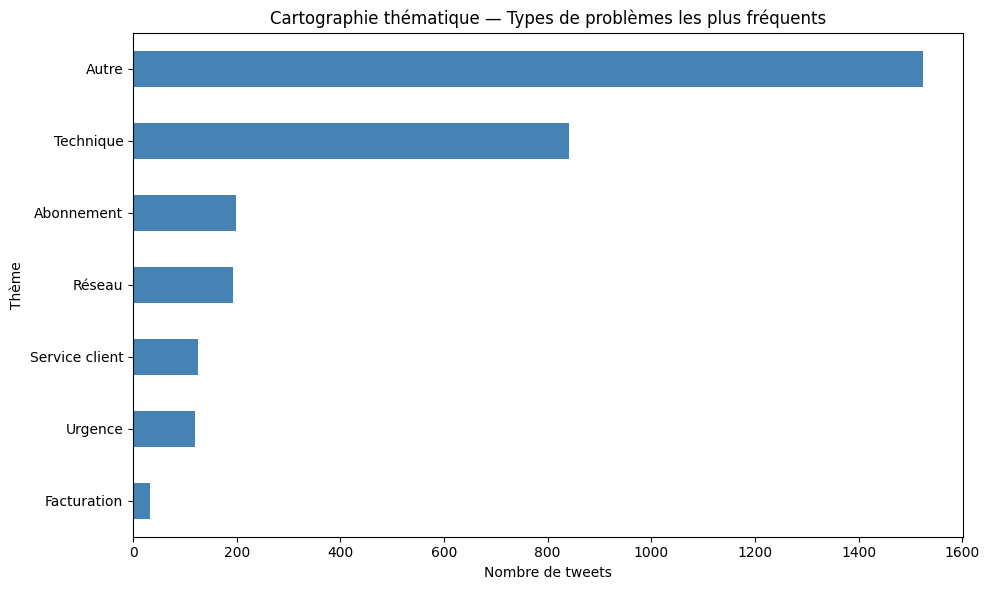

In [186]:
# Compter les occurrences des thèmes
theme_counts = df_client["theme"].value_counts()

plt.figure(figsize=(10, 6))
theme_counts.plot(kind="barh", color="steelblue")

plt.title("Cartographie thématique — Types de problèmes les plus fréquents")
plt.xlabel("Nombre de tweets")
plt.ylabel("Thème")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


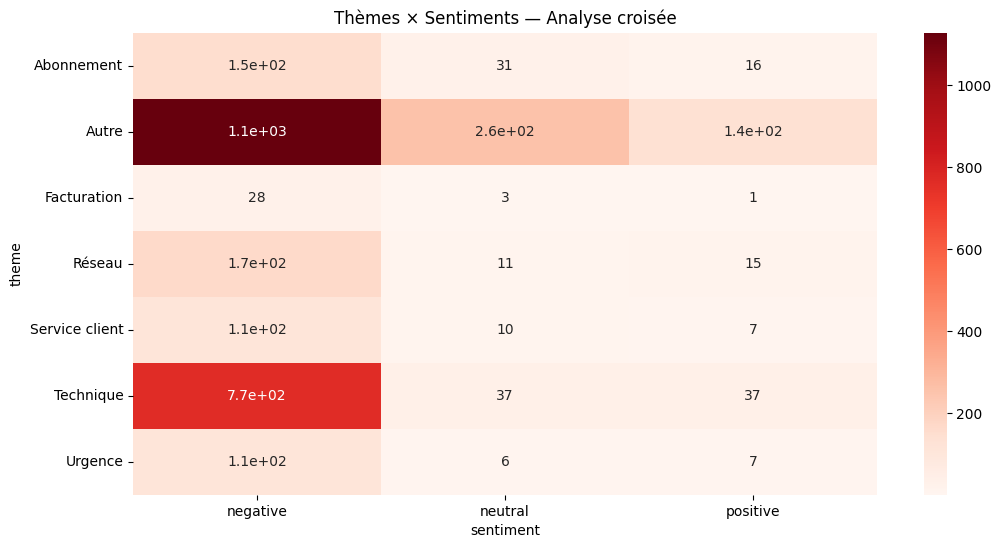

In [187]:
import seaborn as sns

pivot = df_client.groupby(["theme", "sentiment"]).size().unstack(fill_value=0)
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, cmap="Reds")
plt.title("Thèmes × Sentiments — Analyse croisée")
plt.show()


**Analyse de la matrice Thèmes × Sentiments**

Cette représentation permet d’identifier le lien entre le type de problème évoqué dans les tweets et le sentiment exprimé par les utilisateurs.

Les catégories "Autre" et "Technique" concentrent la majorité des tweets.

La catégorie Autre regroupe probablement des messages mal catégorisés, incomplets ou multithèmes.

La catégorie Technique est fortement associée à des tweets négatifs (~770 tweets négatifs), ce qui fait ressortir les difficultés techniques comme une source majeure de frustration.

Les thèmes "Réseau", "Service client" et "Urgence" affichent également une proportion importante de messages négatifs.

Cela renforce l'idée d'incidents prolongés ou d'un manque de réactivité perçu.

Le mot "urgence" associé majoritairement à du négatif montre que les utilisateurs expriment des blocages critiques (ex : absence totale de connexion).

La facturation et l'abonnement représentent une part plus faible dans le volume total, mais leurs mentions restent dominées par un ton négatif.

Les tweets positifs sont quasi absents, signe que ces sujets génèrent rarement une satisfaction déclarée.

Les tweets positifs existent mais restent marginalisés, quelle que soit la catégorie.
Ils semblent plus présents dans les catégories "Technique" et "Autre", ce qui peut correspondre à des messages précédant une résolution ("merci", "c’est réparé").


Pour finir on peut dire que :la heatmap révèle que les tweets négatifs sont fortement concentrés autour des thèmes techniques, suivis par les problématiques liées au réseau, au service client, et aux situations jugées urgentes. Les interactions positives sont rares, ce qui confirme que Twitter est principalement utilisé comme canal de réclamation plutôt que d’appréciation.
Cette carte met clairement en évidence les domaines prioritaires où l’expérience client peut être améliorée — en particulier la résolution technique, la réactivité du support, et la gestion des situations critiques.

/tmp/ipython-input-3845538161.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tweets_total = df_plot.groupby(df_plot["created_at"].dt.to_period("W")).size()
/tmp/ipython-input-3845538161.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tweets_neg = df_plot[df_plot["sentiment"] == "negative"].groupby(df_plot["created_at"].dt.to_period("W")).size()


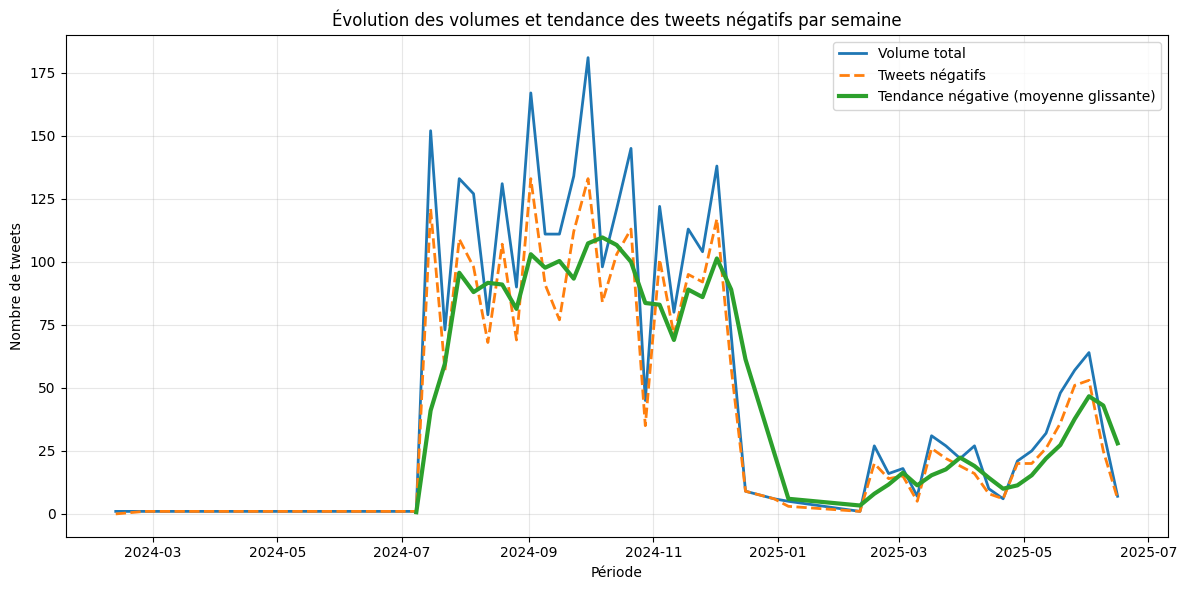

In [188]:
# Volume total vs Volume négatif (par semaine)
df_plot = df_client[df_client["created_at"] >= "2024-01-01"]
tweets_total = df_plot.groupby(df_plot["created_at"].dt.to_period("W")).size()
tweets_neg = df_plot[df_plot["sentiment"] == "negative"].groupby(df_plot["created_at"].dt.to_period("W")).size()
df_visu = pd.DataFrame({
    "Total Tweets": tweets_total,
    "Tweets Négatifs": tweets_neg
}).fillna(0)

df_visu.index = df_visu.index.to_timestamp()
df_visu["Tendance négative (3W MA)"] = df_visu["Tweets Négatifs"].rolling(window=3).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_visu.index, df_visu["Total Tweets"], label="Volume total", linewidth=2)
plt.plot(df_visu.index, df_visu["Tweets Négatifs"], label="Tweets négatifs", linewidth=2, linestyle="dashed")
plt.plot(df_visu.index, df_visu["Tendance négative (3W MA)"], label="Tendance négative (moyenne glissante)", linewidth=3)
plt.title("Évolution des volumes et tendance des tweets négatifs par semaine")
plt.xlabel("Période")
plt.ylabel("Nombre de tweets")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Nombre de tweets par année

/tmp/ipython-input-3989176275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client["date"] = pd.to_datetime(df_client["created_at"], errors="coerce", utc=True)
/tmp/ipython-input-3989176275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client["annee"] = df_client["date"].dt.year


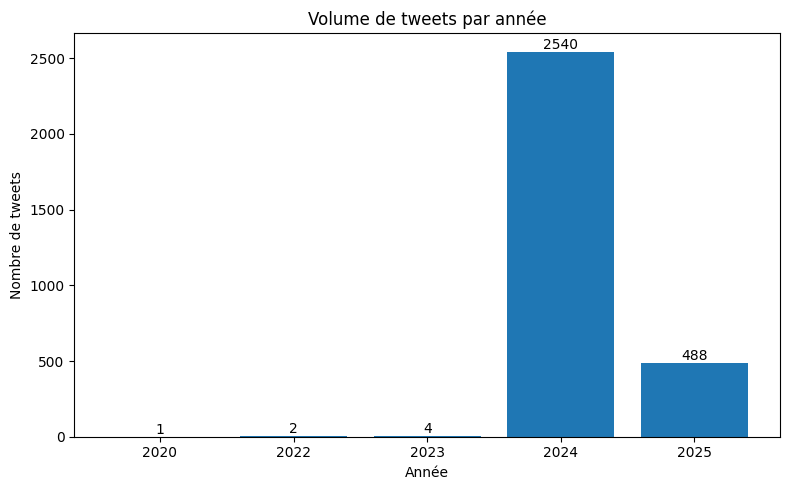

In [189]:
df_client["date"] = pd.to_datetime(df_client["created_at"], errors="coerce", utc=True)
df_client["annee"] = df_client["date"].dt.year
volume_par_annee = df_client["annee"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(volume_par_annee.index.astype(str), volume_par_annee.values)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        str(height),
        ha='center', va='bottom', fontsize=10
    )

plt.title("Volume de tweets par année")
plt.xlabel("Année")
plt.ylabel("Nombre de tweets")
plt.tight_layout()
plt.show()

In [190]:
# Filtre pour la date du 24/07/2019
df_24 = df_client[df_client["created_at"].dt.date == pd.to_datetime("2024-07-19").date()]
df_24["heure"] = df_24["date"].dt.hour
tweets_par_heure = df_24["heure"].value_counts().sort_index()
print(tweets_par_heure)

heure
7      1
8      2
9      1
10     2
11     1
12     1
13     2
14     1
15     2
16     3
17    20
18    72
19     3
20     2
Name: count, dtype: int64


/tmp/ipython-input-2222329960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_24["heure"] = df_24["date"].dt.hour


L'évolution de la journée rouge (avec le plus de tweets)

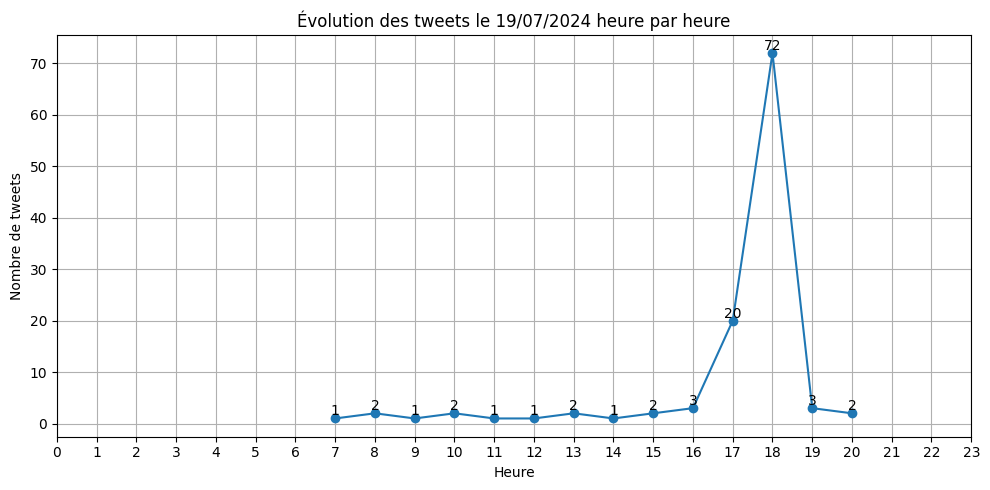

In [191]:
plt.figure(figsize=(10,5))
plt.plot(tweets_par_heure.index, tweets_par_heure.values, marker='o')

for x, y in zip(tweets_par_heure.index, tweets_par_heure.values):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.title("Évolution des tweets le 19/07/2024 heure par heure")
plt.xlabel("Heure")
plt.ylabel("Nombre de tweets")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


Les personnes avec le plus de tweets

screen_name
zoneadsl_panne     11
t_5502m             7
Xavier75            6
BusyspiderFr        5
TiinoX83            5
julienthemonkey     4
ponceto91           4
ArnaudJouzac        4
kronnikeTV          4
Fredo384450         4
Name: count, dtype: int64


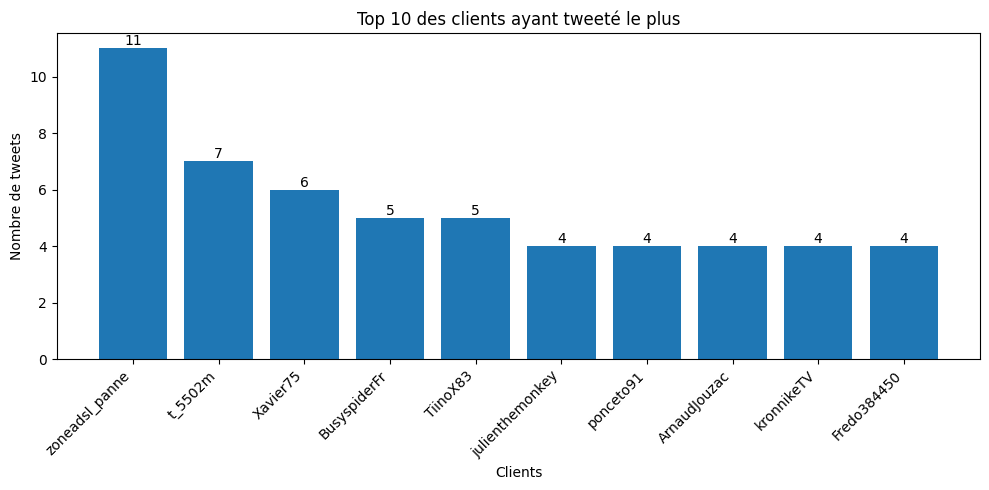

In [192]:
top_clients = df_client["screen_name"].value_counts().head(10)
print(top_clients)


plt.figure(figsize=(10,5))
bars = plt.bar(top_clients.index, top_clients.values)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        str(height),
        ha='center', va='bottom'
    )

plt.title("Top 10 des clients ayant tweeté le plus")
plt.xlabel("Clients")
plt.ylabel("Nombre de tweets")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Analyse de tweets rejetés** :



Proportion de tweets rejetés

In [193]:
rejected_rows = df_client[
    df_client["text_clean"].isna() | (df_client["text_clean"].str.len() < 5)
]
rejected_rows.head()

,id,created_at,full_text,media,screen_name,name,profile_image_url,user_id,in_reply_to,retweeted_status,quoted_status,media_tags,favorite_count,retweet_count,bookmark_count,quote_count,reply_count,views_count,favorited,retweeted,bookmarked,url,lang,text_translated_fr,text_clean,emojis,text_preproc,screen_name_lower,sentiment,score,theme,urgent,date,annee
630,1821424028734620159,2024-08-08 05:51:43+00:00,@excanalla @free tch,[],lauxksk,ʆ𝖆𝘂' 𓂀,https://pbs.twimg.com/profile_images/1879163579040980992/qXFUN2iY_normal.jpg,1560545930633515010,,,,[],0,0,0,0,1,14.0,False,False,False,https://twitter.com/lauxksk/status/1821424028734620159,en,tch,tch,,tch,lauxksk,negative,0.405830,Autre,0,2024-08-08 05:51:43+00:00,2024
1308,1827322415858237448,2024-08-24 12:29:48+00:00,@free ?,[],jaad_soo,jaad,https://pbs.twimg.com/profile_images/1897963478477864960/JB9heF6K_normal.jpg,1367401133795389441,1.8273223294514386e+18,,,[],0,0,0,0,2,54.0,False,False,False,https://twitter.com/jaad_soo/status/1827322415858237448,und,?,,,,jaad_soo,negative,0.347300,Autre,0,2024-08-24 12:29:48+00:00,2024
1449,1829007395697115549,2024-08-29 04:05:19+00:00,@Freebox \n@Free https://t.co/squ6ry5MYf,"[{""type"":""photo"",""url"":""https://t.co/squ6ry5MYf"",""thumbnail"":""https://pbs.twimg.com/media/GWHwh4PWoAE_khz?format=jpg&name=thumb"",""original"":""https://pbs.twimg.com/media/GWHwh4PWoAE_khz?format=jpg&...",ben_aub,Ben Aub,https://pbs.twimg.com/profile_images/1500203837105311748/CLKOfJ0X_normal.jpg,1482140486173405184,,,,[],0,0,0,0,1,17.0,False,False,False,https://twitter.com/ben_aub/status/1829007395697115549,und,,,,,ben_aub,negative,0.347300,Autre,0,2024-08-29 04:05:19+00:00,2024
2303,1836321783399530566,2024-09-18 08:30:05+00:00,? https://t.co/dUQlKjDyT2,"[{""type"":""photo"",""url"":""https://t.co/dUQlKjDyT2"",""thumbnail"":""https://pbs.twimg.com/media/GXvs7JtXUAA6k-b?format=jpg&name=thumb"",""original"":""https://pbs.twimg.com/media/GXvs7JtXUAA6k-b?format=jpg&...",Xavier75,Xavier Niel,https://pbs.twimg.com/profile_images/1846919134837141504/SFkaCgbT_normal.jpg,17744075,,,,[],14373,342,184,47,187,936908.0,False,False,False,https://twitter.com/Xavier75/status/1836321783399530566,und,?,,,,xavier75,negative,0.347300,Autre,0,2024-09-18 08:30:05+00:00,2024
2505,1838733302133395578,2024-09-25 00:12:35+00:00,@MVsheepy @AAgentconnor @lea_cab11 @Freebox Idem…💀,[],haroldao_,Harold AO,https://pbs.twimg.com/profile_images/1485721111371337729/vAR0aM2B_normal.jpg,4053097317,1.8387321491275162e+18,,,[],1,0,0,0,2,142.0,False,False,False,https://twitter.com/haroldao_/status/1838733302133395578,pt,Idem…💀,idem,💀,idem,haroldao_,neutral,0.430155,Autre,0,2024-09-25 00:12:35+00:00,2024


In [194]:
rejected_rows = df_client[
    df_client["text_clean"].isna() | (df_client["text_clean"].str.len() < 5)
]
nb_rejects = len(rejected_rows)
print(f"Nombre de tweets rejetés : {nb_rejects}")

Nombre de tweets rejetés : 18


In [195]:
total = len(df_client)
pourcentage_rejet = (nb_rejects / total) * 100
print(f"Pourcentage de tweets rejetés : {pourcentage_rejet:.2f}%")

Pourcentage de tweets rejetés : 0.59%


In [196]:
# Le type de tweets rejetés
df_client["rejet_type"] = df_client["text_clean"].apply(
    lambda x: "NaN" if pd.isna(x) else "Trop court" if len(str(x)) < 5 else "OK"
)
print(df_client["rejet_type"].value_counts(normalize=True) * 100)

rejet_type
OK            99.406919
Trop court     0.593081
Name: proportion, dtype: float64


/tmp/ipython-input-1086961747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client["rejet_type"] = df_client["text_clean"].apply(


In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from textblob import TextBlob

# --- Paramètres / chemins ---
CSV_PATH = r"d:\code python\free tweet export.csv"
OUT_PARQUET = r"d:\code python\tweets_frontend.parquet"

# lecture robuste (quelques encodages courants)
def read_csv_robust(path):
    for enc in ("utf-8","utf-8-sig","latin-1","cp1252"):
        try:
            return pd.read_csv(path, encoding=enc, keep_default_na=False)
        except Exception as e:
            last = e
    raise last

df_raw = read_csv_robust(CSV_PATH)

# Normalisation colonnes essentielles
for c in ['id','created_at','full_text','screen_name','name']:
    if c not in df_raw.columns:
        df_raw[c] = ''

# Filtrer : supprimer tous les tweets dont le client (screen_name) est 'free' (case-insensitive)
df = df_raw.copy()
df['screen_name_lower'] = df['screen_name'].astype(str).str.lower()
df = df[df['screen_name_lower'] != 'free'].reset_index(drop=True)

# Canal : 'tweeter' pour ces données (si source connue), sinon '-'
df['Canal'] = np.where(df['screen_name'].notna(), 'tweeter', '-')

# Statut : quand Canal == 'tweeter' => 'fermé' (conformité spec)
df['Statut'] = np.where(df['Canal']=='tweeter', 'fermé', '-')

# Historique des échanges : message brut (full_text) incluant émoticônes
df['Historique des échanges'] = df['full_text'].astype(str)

# Date
df['Date'] = pd.to_datetime(df['created_at'], errors='coerce')

# Client (nom affiché dans dashboard) : privilégie 'name' puis 'screen_name'
df['Client'] = df['name'].where(df['name'].astype(bool), df['screen_name'])

# IDENTIFIANT : fournir à la fois ID (original) et Ticket (format T-<id>)
df['ID'] = df['id'].astype(str)
df['Ticket'] = 'T-' + df['ID']

# Détection simple de motif / thème (heuristique via mots-clés)
theme_map = {
    'Technique': ['panne','connexion','wifi','décodeur','box','erreur','internet','connexion','débit','oqee','authentification'],
    'Facturation': ['facture','paiement','prélèvement','remboursement','dédommagement','facturation'],
    'Abonnement': ['abonnement','résiliation','forfait','offre','migration','ultra','freebox'],
    'Service client': ['assistance','support','hotline','appel','injoignable','contact'],
    'Réseau': ['réseau','4g','5g','fibre','coupure','synchro','serveur'],
}

def detect_motif(text):
    if not isinstance(text, str) or text.strip()=='' :
        return 'Autre'
    t = text.lower()
    for theme, words in theme_map.items():
        for w in words:
            if w in t:
                return theme
    # fallback : court résumé
    return (t[:80] + '...') if len(t) > 80 else t

df['Motif'] = df['Historique des échanges'].apply(detect_motif)

# Gravité heuristique : urgent keywords or strong negative sentiment -> 'critique'/'eleve' else 'moyen'/'faible'
urgent_patterns = [r'urgent', r"aucun accès", r"plus d'internet", r'bloqu', r'authentif', r'erreur 20', r'etape [23-9]']
def compute_gravite(text, polarity):
    t = (text or '').lower()
    if any(re.search(p, t) for p in urgent_patterns):
        return 'eleve'
    if polarity is None:
        return 'moyen'
    if polarity < -0.5:
        return 'critique'
    if polarity < -0.15:
        return 'eleve'
    if polarity < 0.1:
        return 'moyen'
    return 'faible'

# Recommandation via score de sentiment (TextBlob) -> simple mapping
def analyse_recommandation(text):
    if not isinstance(text, str) or text.strip()=='':
        return pd.Series([None, None])
    try:
        tb = TextBlob(text)
        polarity = tb.sentiment.polarity
    except Exception:
        polarity = 0.0
    # Règles de recommandation basiques
    if polarity <= -0.5:
        rec = 'Escalader au support technique - réponse urgente (root cause)'
    elif polarity <= -0.15:
        rec = 'Priorité : contacter client et planifier intervention / vérification réseau'
    elif polarity <= 0.1:
        rec = 'Suivi standard - prendre en charge et monitorer'
    else:
        rec = 'Pas d action urgente - surveiller / remercier si résolution'
    return pd.Series([polarity, rec])

sent = df['Historique des échanges'].apply(analyse_recommandation)
df['sentiment_score'] = sent.iloc[:,0].values
df['Recommandation'] = sent.iloc[:,1].values

# Gravité calculée
df['Gravité'] = df.apply(lambda r: compute_gravite(r['Historique des échanges'], r['sentiment_score']), axis=1)

# Agent par défaut (pas d'info dans le flux Twitter) -> '-'
df['Agent'] = '-'

# Conserver en sortie les colonnes attendues par le frontend / dashboard
output_cols = [
    'Ticket', 'ID', 'Client', 'Motif', 'Statut', 'Gravité', 'Canal', 'Date', 'Agent',
    'Historique des échanges', 'Recommandation', 'sentiment_score',
    # garder aussi quelques métriques originales utiles pour dashboards
    'favorite_count', 'retweet_count', 'reply_count'
]

# Ajouter colonnes manquantes dans output_cols si absentes
for c in output_cols:
    if c not in df.columns:
        df[c] = None

df_out = df[output_cols].copy()

# Sauvegarde Parquet (essayer pyarrow sinon fallback vers csv et informer)
def save_parquet(df, path):
    try:
        import pyarrow  # type: ignore
        df.to_parquet(path, index=False, engine='pyarrow')
        print(f'Parquet écrit -> {path}')
    except Exception as e:
        print('Échec écriture parquet avec pyarrow :', e)
        csv_fallback = str(Path(path).with_suffix('.csv'))
        df.to_csv(csv_fallback, index=False, encoding='utf-8-sig')
        print('Fallback CSV écrit ->', csv_fallback)

save_parquet(df_out, OUT_PARQUET)

# Affichage rapide
print('Total tweets originaux:', len(df_raw))
print('Après filtrage (exclu compte free):', len(df))
df_out.head(10)